# Data Analysis

In this notebook we perform data analysis on a BERT model trained for 5 epochs, using the 'cleaned' data and using fine-tuning of the whole model.

In [ ]:
#!pip install rich

In [2]:
import numpy as np # linear algebra
import pandas as pd
import json
import re
import os
import pandas as pd
import pickle
import sklearn

from tqdm import tqdm,trange
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Progbar
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,accuracy_score
import torch
from transformers import BertForTokenClassification, AdamW, BertTokenizerFast
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler, Sampler
from typing import Iterator, Optional, Sequence, List, TypeVar, Generic, Sized
#from rich.console import Console
#from rich.progress import track
from tqdm import tqdm
from transformers import BertTokenizerFast,BertForTokenClassification

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
print(f'Using {device} device')

Using cuda device


In [4]:
def timer(func):
    """
    Record execution time of any function with timer decorator
    Usage: just decorate a function when building it, the 
    decorator will be called every time the function is executed.
    # build the function
    @timer
    def some_function(some_arg):
        # do_something
        return 'foo'
        
    # call it
    some_function('boo')
    # output:
    >> Function 'some_function' finished after 0.01 seconds.
    """

    def wrapper(*args, **kwargs):
        start = time.time()
        results = func(*args, **kwargs)
        duration = time.time() - start
        print("Function '{}' finished after {:.4f} seconds."\
              .format(func.__name__, duration))
        return results
    return wrapper

# Data Preparation

In [5]:
class Pipeline:

    def __init__(self, configs):
        self.configs = configs
        self.tokenizer = None

    def set_tokenizer(self, tokenizer):
        """
        Set a custom tokenizer to be used when running the pipeline.
        If not, this will default to BERTTokenizerFast in `run()`
        """
        self.tokenizer = tokenizer

    def tokenize_and_preserve_labels(self, tupled_sentence):
        tokenized_sentence = []
        labels = []

        for (word, label) in tupled_sentence:

            # Tokenize the word
            tokenized_word = self.tokenizer.tokenize(word)
            tokenized_sentence.extend(tokenized_word)
            
            # Repeat the label for words that are broken up into several tokens
            labels.extend([label]*len(tokenized_word))
            
        # Add the tokenized word and its label to the final tokenized word list
        return list(zip(tokenized_sentence, labels))

    def add_start_end_tokens(self, tupled_sentence):
        tupled_sentence.insert(0, ('[CLS]', 'O'))
        tupled_sentence.append(('[SEP]', 'O'))
        return tupled_sentence

    def add_padding(self, tokenized_sentences, labels):
        # Note that this implicitly converts to an array of objects (strings)
        
        padded_sentences = pad_sequences(
            tokenized_sentences, 
            value='[PAD]', 
            dtype=object, 
            maxlen=self.configs.MAX_LENGTH, 
            truncating='post', 
            padding='post')

        padded_labels = pad_sequences(
            labels, 
            value='O', 
            dtype=object, 
            maxlen=self.configs.MAX_LENGTH, 
            truncating='post', 
            padding='post')
        
        return padded_sentences, padded_labels

    def get_attention_mask(self, input_ids, ignore_tokens=[0,101,102]):
        """
        Compute the attention marks for the tokens in `input_ids`, which is
        assumed to be a list (batch) of lists (sentences) of integer tokens.
        Tokens that should be masked out can be specified using the 
        `ignore_tokens` parameter. By default, these are supposed to be 0, 101,
        and 102, representing [PAD], [CLS], and [SEP] tokens, respectively.
        """

        return [
            [ float(token not in ignore_tokens) for token in sent ] 
                for sent in input_ids
        ]

    def run(self, ner_data):
        """
        Run extracted sentence data through the pipeline.
        """

        console = Console()

        # Initialize tokenizer
        if not self.tokenizer:
            self.tokenizer = BertTokenizerFast.from_pretrained(
                'bert-base-cased', do_lower_case=False)
            console.log('Initialized default BERT tokenizer')
        else:
            console.log('Using custom tokenizer')

        # Tokenize into known tokens
        ner_data = [
            self.tokenize_and_preserve_labels(sentence) for sentence in 
                track(ner_data, description='Tokenizing words...')
        ]
        console.log('Tokenized words')

        with console.status("[bold green]Running pipeline...") as status:

            # Add [CLS] and [SEP] tokens to beginning and end
            ner_data = [
                self.add_start_end_tokens(sentence)
                    for sentence in ner_data
            ]
            console.log('Added [CLS] and [SEP] tokens')

            # Get only sentences, not labels
            tokenized_sentences = [
                [token_label_tuple[0] for token_label_tuple in sent]
                    for sent in ner_data
            ]

            # Get only labels, not sentences
            labels = [
                [token_label_tuple[1] for token_label_tuple in sent] 
                    for sent in ner_data 
            ]

            # Pad sentences and labels 
            padded_sentences, padded_labels = self.add_padding(
                tokenized_sentences, labels)
            console.log('Padded sentences and labels')

            # Convert to integer ids
            input_ids = [
                self.tokenizer.convert_tokens_to_ids(text) 
                    for text in padded_sentences
            ]
            tags = [
                self.tokenizer.convert_tokens_to_ids(text) 
                    for text in padded_labels
            ]
            console.log('Converted to integer ids')

            # Compute attention mask from input tokens
            attention_mask = self.get_attention_mask(
                input_ids,
                # Only ignore [PAD] tokens (integer 0)
                ignore_tokens=[0]
            )
            
            console.log('Computed attention mask')

        if self.configs.SAVE:
            ParseUtils.save_file(
                {
                    'input_ids': input_ids, 
                    'tags': tags,
                    'attention_mask': attention_mask
                },
                self.configs.DATA_PATH,
                self.configs.TOKENIZED_FILENAME
            )

        return input_ids, tags, attention_mask

    def load_outputs(self):
        """
        Recover the outputs of a previously completed run from storage.
        """
        output_dict = ParseUtils.load_file(
            self.configs.DATA_PATH,
            self.configs.TOKENIZED_FILENAME,
        )

        return output_dict['input_ids'], \
               output_dict['tags'], \
               output_dict['attention_mask']

    def extract(self):
        ner_data = ParseUtils.extract(
            max_len = self.configs.MAX_LENGTH,
            overlap = self.configs.OVERLAP,
            max_sample = self.configs.MAX_SAMPLE,
            max_text_tokens = self.configs.MAX_TEXT_TOKENS,
            train_df_path = self.configs.TRAIN_DF_PATH,
            train_data_path = self.configs.TRAIN_DATA_PATH,
            ignore_label_case = self.configs.IGNORE_LABEL_CASE,
            exclude_non_exact_label_match = self.configs.EXCLUDE_NON_EXACT_LABEL_MATCH
        )

        # Write data to file
        if self.configs.SAVE:
            ParseUtils.save_extracted(
                ner_data, 
                self.configs.DATA_PATH, 
                self.configs.EXTRACTED_FILENAME
            )

        return ner_data

    def load_extracted(self):
        return ParseUtils.load_extracted(
            self.configs.DATA_PATH, 
            self.configs.EXTRACTED_FILENAME
        )


class PipelineConfigs:

    def __init__(
        self,
        DATA_PATH,
        SAVE,
        EXTRACTED_FILENAME,
        TOKENIZED_FILENAME,
        MAX_SAMPLE,
        MAX_LENGTH = 64,
        OVERLAP = 20,
        MAX_TEXT_TOKENS=200000,
        IGNORE_LABEL_CASE=True,
        EXCLUDE_NON_EXACT_LABEL_MATCH=True
    ):

        # Maximum number of words for each sentence
        self.MAX_LENGTH = MAX_LENGTH

        # If a sentence exceeds MAX_LENGTH, we split it to multiple sentences 
        # with overlapping
        self.OVERLAP = OVERLAP

        # During development, you may want to only load part of the data. Leave
        # uninitialized during production
        self.MAX_SAMPLE = MAX_SAMPLE

        self.DATA_PATH = DATA_PATH
        #self.DATA_PATH = \
        #    os.path.join(
        #        os.path.join(
        #            os.path.dirname(
        #                os.path.dirname(
        #                    os.path.dirname(
        #                        os.path.dirname(__file__)
        #                    )
        #                )
        #            ),
        #            'data'
        #        ), 
        #        'coleridgeinitiative-show-us-the-data'
        #    )
        self.TRAIN_DATA_PATH = os.path.join(self.DATA_PATH, 'train')
        self.TRAIN_DF_PATH = os.path.join(self.DATA_PATH, 'train.csv')
        self.TEST_DATA_PATH = os.path.join(self.DATA_PATH, 'test')

        # If SAVE is true, will save the extracted and/or the tokenized data
        # under the provided filename(s)
        self.SAVE = SAVE
        self.EXTRACTED_FILENAME = EXTRACTED_FILENAME
        self.TOKENIZED_FILENAME = TOKENIZED_FILENAME
        # Maximum amount of tokens in training texts. Longer texts will be discarded
        self.MAX_TEXT_TOKENS = MAX_TEXT_TOKENS
        # Whether the tagger should ignore the case of the label when matching labels to the text
        self.IGNORE_LABEL_CASE = IGNORE_LABEL_CASE
        # Whether to exclude texts that do not have a single one-on-one (case insensitve) label match
        self.EXCLUDE_NON_EXACT_LABEL_MATCH = EXCLUDE_NON_EXACT_LABEL_MATCH


In [6]:

class ParseUtils:

    @staticmethod
    def count_in_json(json_id, label, train_data_path):
        path_to_json = os.path.join(train_data_path, (json_id + '.json'))
        count_dict = {}
        with open(path_to_json, 'r') as f:
            json_decode = json.load(f)
            for data in json_decode:
                heading = data.get('section_title')
                content = data.get('text')
                count_dict[heading] = content.count(heading)
        return count_dict

    @staticmethod
    def shorten_sentences(sentences, max_len, overlap):
        short_sentences = []
        for sentence in sentences:
            words = sentence.split()
            if len(words) > max_len:
                for p in range(0, len(words), max_len - overlap):
                    short_sentences.append(' '.join(words[p:p + max_len]))
            else:
                short_sentences.append(sentence)
        return short_sentences

    @staticmethod
    def clean_training_text(txt):
        """
        similar to the default clean_text function but without lowercasing.
        """
        txt = re.sub('[^A-Za-z0-9]+', ' ', str(txt)).strip()

        return txt

    @staticmethod
    def find_sublist(big_list, small_list):
        all_positions = []
        for i in range(len(big_list) - len(small_list) + 1):
            if small_list == big_list[i:i + len(small_list)]:
                all_positions.append(i)

        return all_positions

    @staticmethod
    def tag_sentence(sentence, labels, ignore_case):  # requirement: both sentence and
        re_flags = re.IGNORECASE if ignore_case else None

        # labels are already cleaned
        sentence_words = sentence.split()

        if labels is not None and any(re.findall(f'\\b{label}\\b', sentence,
                                                 flags=re_flags) for label in labels):  # positive sample
            nes = ['O'] * len(sentence_words)
            for label in labels:
                label_words = label.split()

                if ignore_case:
                    nocase_label_words = list(map(lambda word: word.lower(), label_words))
                    nocase_sentence_words = list(map(lambda word: word.lower(), sentence_words))
                    all_pos = ParseUtils.find_sublist(nocase_sentence_words, nocase_label_words)
                else:
                    all_pos = ParseUtils.find_sublist(sentence_words, label_words)

                for pos in all_pos:
                    nes[pos] = 'B'
                    for i in range(pos + 1, pos + len(label_words)):
                        nes[i] = 'I'

            return True, list(zip(sentence_words, nes))

        else:  # negative sample
            nes = ['O'] * len(sentence_words)
            return False, list(zip(sentence_words, nes))

    @staticmethod
    def read_append_return(filename, train_data_path, output='text'):
        """
        Function to read json file and then return the text data from them and append to the dataframe

        Basicall parse json but then from https://www.kaggle.com/prashansdixit/coleridge-initiative-eda-baseline-model
        """
        json_path = os.path.join(train_data_path, (filename + '.json'))
        headings = []
        contents = []
        combined = []
        with open(json_path, 'r') as f:
            json_decode = json.load(f)
            for data in json_decode:
                headings.append(data.get('section_title'))
                contents.append(data.get('text'))
                combined.append(data.get('section_title'))
                combined.append(data.get('text'))

        all_headings = ' '.join(headings)
        all_contents = ' '.join(contents)
        all_data = '. '.join(combined)

        if output == 'text':
            return all_contents
        elif output == 'head':
            return all_headings
        else:
            return all_data

    @staticmethod
    def save_extracted(ner_data, data_path, file_name):
        with open(os.path.join(data_path, file_name), 'w') as f:
            for row in ner_data:
                words, nes = list(zip(*row))
                row_json = {'tokens': words, 'tags': nes}
                json.dump(row_json, f)
                f.write('\n')

    @staticmethod
    def load_extracted(data_path, file_name):

        ner_data = []
        f = open(os.path.join(data_path, file_name), 'r')

        for line in f.readlines():
            # Each line is formatted in JSON format, e.g.
            # { "tokens" : ["A", "short", "sentence"],
            #   "tags"   : ["0", "0", "0"] }
            sentence = json.loads(line)

            # From the tokens and tags, we create a list of 
            # tuples of the form
            # [ ("A", "0"), ("short", "0"), ("sentence", "0")]
            sentence_tuple_list = [
                (token, tag) for token, tag
                in zip(sentence["tokens"], sentence["tags"])
            ]

            # Each of these parsed sentences becomes an entry
            # in our overall data list
            ner_data.append(sentence_tuple_list)

        f.close()
        return ner_data

    @staticmethod
    def save_file(output, data_path, file_name):
        with open(os.path.join(data_path, file_name), 'wb') as f:
            pickle.dump(output, f)

    @staticmethod
    def load_file(data_path, file_name):
        with open(os.path.join(data_path, file_name), 'rb') as f:
            output = pickle.load(f)
        return output

    @staticmethod
    def all_labels_mentioned(data):
        """
        Method that can be applied to a dataframe and check, for all dataset labels, if they occur in the text at least
        once. Case insensitive
        """
        labels = data['dataset_label'].split("|")
        return all(list(map(lambda label: data['text'].lower().count(label.lower()) > 0, labels)))

    @staticmethod
    def extract(
            max_len,
            overlap,
            max_sample,
            max_text_tokens,
            train_df_path,
            train_data_path,
            ignore_label_case,
            exclude_non_exact_label_match

    ):
        """
        Reads the training data from storage using the train.csv file as well
        as all json files inside the train folder, and computes a list,
        where each element is a sentence. Each sentence is itself a list, 
        consisting of tuples, where the first element is the word (token) and
        the second is the label (tag).

        This is an example of the data list returned:

            ner_data = [
                ...
                [
                    ("This", "0"),
                    ("is", "0"),
                    ("New", "LOC"),
                    ("York", "LOC"),
                ],
                ...
            ]

        If `save` is True, the data will be stored on disk in the DATA_PATH
        directory in a single text file, where each line is in JSON format, e.g.
        
            { "tokens" : ["A", "short", "sentence"], "tags" : ["0", "0", "0"] }
        """

        # Read data in CSV file
        train = pd.read_csv(train_df_path)
        train = train[:max_sample]
        print(f'Found {len(train)} raw training rows')

        # Group rows by publication ID
        train = train.groupby('Id').agg({
            'pub_title': 'first',
            'dataset_title': '|'.join,
            'dataset_label': '|'.join,
            'cleaned_label': '|'.join
        }).reset_index()
        print(f'Found {len(train)} unique training rows')

        print('Loading texts, this might take a while...')
        # Read texts for text length analysis
        train['text'] = train['Id'].apply(lambda ID: ParseUtils.read_append_return(ID, train_data_path))
        train['text_token_length'] = train['text'].apply(lambda text: len(text))

        # Remove texts that have more tokens than max_text_tokens
        train = train[train['text_token_length'] <= max_text_tokens]
        print(f'Removed texts exceeding max length, {len(train)} training rows left')

        if exclude_non_exact_label_match:
            # Count label mentions in text
            train["all_labels_mentioned"] = train.apply(ParseUtils.all_labels_mentioned, axis=1)

            # Remove texts that have 0 label count for at least 1 label
            train = train[train['all_labels_mentioned']]
            print(f'Removed texts that had at least one label with 0 exact (case insenstive) matches in the text, '
                  f'{len(train)} training rows left')

        # Read individual papers by ID from storage
        papers = {}
        for paper_id in train['Id'].unique():
            with open(f'{train_data_path}/{paper_id}.json', 'r') as f:
                paper = json.load(f)
                papers[paper_id] = paper

        cnt_pos, cnt_neg = 0, 0  # number of sentences that contain/not contain labels
        ner_data = []

        pbar = tqdm(total=len(train))
        for i, id, dataset_label in train[['Id', 'dataset_label']].itertuples():
            # paper
            paper = papers[id]

            # labels
            labels = dataset_label.split('|')
            labels = [ParseUtils.clean_training_text(label) for label in labels]

            # sentences
            sentences = set([
                ParseUtils.clean_training_text(sentence)
                for section in paper
                for sentence in section['text'].split('.')
            ])
            sentences = ParseUtils.shorten_sentences(
                sentences, max_len, overlap)

            # only accept sentences with length > 10 chars
            sentences = [sentence for sentence in sentences if len(sentence) > 10]

            # positive sample
            for sentence in sentences:
                is_positive, tags = ParseUtils.tag_sentence(sentence, labels, ignore_label_case)
                if is_positive:
                    cnt_pos += 1
                    ner_data.append(tags)
                elif any(word in sentence.lower() for word in ['data', 'study']):
                    ner_data.append(tags)
                    cnt_neg += 1

            # process bar
            pbar.update(1)
            pbar.set_description(f"Training data size: {cnt_pos} positives + {cnt_neg} negatives")

        # shuffling
        # random.shuffle(ner_data)

        return ner_data


In [7]:
data_path ='../input/showusthedata-tokenized'

In [8]:
configs = PipelineConfigs(
    DATA_PATH = data_path,
    MAX_LENGTH = 64,
    OVERLAP = 20,
    MAX_SAMPLE = None,
    SAVE = False,
    EXTRACTED_FILENAME = 'train_ner.data',
    TOKENIZED_FILENAME = 'train_ner.data.tokenized',
)

In [9]:
pipeline = Pipeline(configs)

In [10]:
input_ids, tags, attention_mask = pipeline.load_outputs()

In [11]:
tag_values=np.unique(tags)

In [12]:
tag2id = {t:i for i, t in enumerate(np.unique(tags))}
tags = [[tag2id[tag] for tag in sent] for sent in tags]

In [13]:
_, val_inputs, _, val_tags = train_test_split(input_ids,tags,random_state=2018,test_size=0.1)
_, val_masks,_ ,_ = train_test_split(attention_mask,input_ids,random_state=2018,test_size=0.1)

In [14]:
val_inputs = torch.tensor(val_inputs).to(device)
val_tags = torch.tensor(val_tags).to(device)
val_masks = torch.tensor(val_masks).to(device)

In [15]:
BATCH_SIZE = 64

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=BATCH_SIZE)

# Defining Model

In [16]:
#model_path = '../input/huggingface-bert/bert-base-cased'
model_path = '../input/bert-finetuned-5eps'

In [17]:
model = BertForTokenClassification.from_pretrained(
    model_path,
    num_labels=3,
    output_attentions = False,
    output_hidden_states = False
).to(device)

In [18]:
loss_values, validation_loss_values = [], []
n_valid_steps = len(valid_dataloader)
all_predictions = None

model.eval()
# Reset the validation loss for this epoch.
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0
predictions , true_labels = [], []

pbar = Progbar(n_valid_steps)
for step, batch in enumerate(valid_dataloader):

    #print(f'Valid step {step}/{n_valid_steps}\r', end='')

    #batch = tuple(t.to('cpu') for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    # Telling the model not to compute or store gradients,
    # saving memory and speeding up validation
    with torch.no_grad():
        # Forward pass, calculate logit predictions.
        # This will return the logits rather than the loss because we have not provided labels.
        outputs = model(b_input_ids,
                        attention_mask=b_input_mask, 
                        labels=b_labels)

    # Move logits and labels to CPU
    logits = outputs[1].detach().cpu().numpy()
    if all_predictions is None:
        all_predictions = np.argmax(logits, axis=2)
    else:
        all_predictions = np.vstack((all_predictions, np.argmax(logits, axis=2)))
    label_ids = b_labels.to('cpu').numpy()

    # Calculate the accuracy for this batch of test sentences.
    loss_val = outputs[0].mean().item()
    eval_loss += loss_val
    predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
    true_labels.extend(label_ids)

    pbar.update(step+1, [('Valid loss', loss_val)])

eval_loss = eval_loss / len(valid_dataloader)
validation_loss_values.append(eval_loss)
#print("Valid Loss: {:.8f}".format(eval_loss))
pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                             for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
valid_tags = [tag_values[l_i] for l in true_labels
                              for l_i in l if tag_values[l_i] != "PAD"]
print("Valid Accuracy: {:2.2f}%".format(100*accuracy_score(pred_tags, valid_tags)))
print("Valid F1-Score: {:2.2f}%, {:2.2f}%, {:2.2f}%".format(*f1_score(pred_tags, valid_tags,average=None)*100))
print()

718/718 [==============================] - 90s 125ms/step - Valid loss: 0.0023
Valid Accuracy: 99.20%
Valid F1-Score: 63.32%, 65.86%, 99.60%



In [19]:
val_inputs, val_masks, val_tags = val_inputs.cpu().numpy(), val_masks.cpu().numpy(), val_tags.cpu().numpy()

In [21]:
"""
Code from:
https://www.kaggle.com/grfiv4/plot-a-confusion-matrix
"""

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

## Confusion matrices

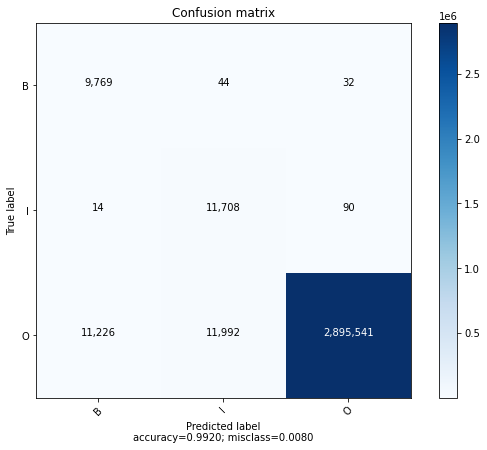

In [22]:
cm = sklearn.metrics.confusion_matrix(val_tags.reshape(val_tags.shape[0] * val_tags.shape[1]), all_predictions.reshape(all_predictions.shape[0] * all_predictions.shape[1]))
plot_confusion_matrix(cm, ["B", "I", "O"], normalize=False)

Note that performance is quite good, with only a very small amount of labels being misclassified. However, we see quite a lot of wrong predictions for the O label, how come? Lets look at some examples:

In [ ]:
indices = []
for t in range(val_tags.shape[0]):
    for w in range(len(np.where(val_masks[t] == 1.0)[0])):
        if val_tags[t, w] != all_predictions[t, w]:
            indices.append(t)
indices = np.unique(indices)
print("Texts with errors:", len(indices))

In [37]:
def inspect_sentence(i, val_inputs, val_masks, val_tags, predictions):
    tokenizer_path = '../input/huggingface-bert/bert-base-cased'
    tokenizer = BertTokenizerFast.from_pretrained(tokenizer_path, do_lower_case=False)
    sentence = tokenizer.convert_ids_to_tokens(val_inputs[i])
    print("Words\t\tTrue pred")
    for token in range(len(sentence)):
        print(sentence[token],"\t\t", val_tags[i][token], predictions[i][token], "<--" if val_tags[i][token] != predictions[i][token] else "")

In [38]:
inspect_sentence(indices[0], val_inputs, val_masks, val_tags, predictions)

Words		True pred
[CLS] 		 2 2 
For 		 2 2 
these 		 2 2 
schools 		 2 2 
we 		 2 2 
can 		 2 2 
identify 		 2 2 
their 		 2 2 
school 		 2 2 
district 		 2 2 
and 		 2 2 
merge 		 2 2 
on 		 2 2 
district 		 2 2 
level 		 2 2 
information 		 2 2 
about 		 2 2 
school 		 2 2 
finances 		 2 2 
from 		 2 2 
the 		 2 2 
NC 		 2 0 <--
##ES 		 2 0 <--
Common 		 0 0 
Core 		 1 1 
of 		 1 1 
Data 		 1 1 
[SEP] 		 2 2 
[PAD] 		 2 2 
[PAD] 		 2 2 
[PAD] 		 2 2 
[PAD] 		 2 2 
[PAD] 		 2 2 
[PAD] 		 2 2 
[PAD] 		 2 2 
[PAD] 		 2 2 
[PAD] 		 2 2 
[PAD] 		 2 2 
[PAD] 		 2 2 
[PAD] 		 2 2 
[PAD] 		 2 2 
[PAD] 		 2 2 
[PAD] 		 2 2 
[PAD] 		 2 2 
[PAD] 		 2 2 
[PAD] 		 2 2 
[PAD] 		 2 2 
[PAD] 		 2 2 
[PAD] 		 2 2 
[PAD] 		 2 2 
[PAD] 		 2 2 
[PAD] 		 2 2 
[PAD] 		 2 2 
[PAD] 		 2 2 
[PAD] 		 2 0 <--
[PAD] 		 2 2 
[PAD] 		 2 1 <--
[PAD] 		 2 1 <--
[PAD] 		 2 2 
[PAD] 		 2 2 
[PAD] 		 2 2 
[PAD] 		 2 2 
[PAD] 		 2 2 
[PAD] 		 2 2 


We find errors in the padding, which are counted as well! Lets rerun the confusion matrix excluding the effect of the padding:

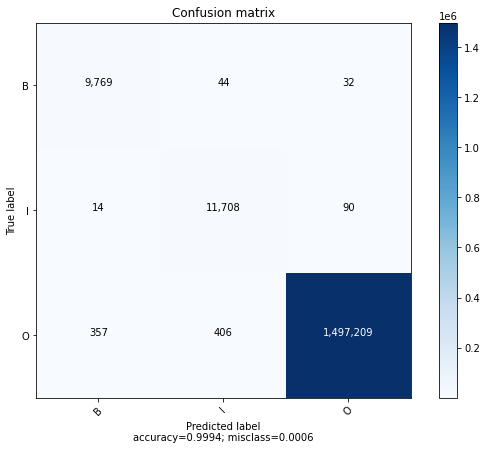

In [39]:
mask = np.where(val_masks.reshape(val_tags.shape[0] * val_tags.shape[1]))[0]
cm_mask = sklearn.metrics.confusion_matrix(val_tags.reshape(val_tags.shape[0] * val_tags.shape[1])[mask], all_predictions.reshape(all_predictions.shape[0] * all_predictions.shape[1])[mask])
plot_confusion_matrix(cm_mask, ["B", "I", "O"], normalize=False)

This changed nothing for the B and I labels (which makes sense, since all padding should have the O label). However, for the O label, this drastically reduced the amount of wrong classifications. However, we still have quite some classifications that are wrong. Lets summarize the errors made:

In [58]:
class ModelError:
    PRINT_FORMAT = '{:<20} {:<4} {:<4} {:<2}'
    def __init__(self, token, y_true, y_pred):
        self.tokens = [token]
        self.y_trues = [y_true]
        self.y_preds = [y_pred]
        
    def add_token(self, token, y_true, y_pred):
        self.tokens.append(token)
        self.y_trues.append(y_true)
        self.y_preds.append(y_pred)
        
        
    def __str__(self):
        string = ""
        for i in range(len(self.tokens)):
            string += self.PRINT_FORMAT.format(self.tokens[i], '', str(self.y_trues[i]), str(self.y_preds[i])+"\n")
        return string
        
    def __eq__(self, other):
        return self.tokens == other.tokens and \
        self.y_trues == other.y_trues and \
        self.y_preds == other.y_preds
    
    def __ne__(self, other):
        return not self == other
    
    def __lt__(self, other):
        string = ""
        for i in range(len(self.tokens)):
            string += self.tokens[i]
        string = string.replace("#", "")
        
        otherstring = ""
        for i in range(len(other.tokens)):
            otherstring += other.tokens[i]
        otherstring = otherstring.replace("#", "")
        
        return string < otherstring

In [59]:
def summarize_errors(indices, val_inputs, val_masks, val_tags, predictions):
    prev = False
    errors = []
    current_error = None
    tokenizer_path = '../input/huggingface-bert/bert-base-cased'
    tokenizer = BertTokenizerFast.from_pretrained(tokenizer_path, do_lower_case=False)
    for t in indices:
        sentence = tokenizer.convert_ids_to_tokens(val_inputs[t][np.where(val_masks[t] == 1.0)])
        for token in range(len(sentence)):
            if val_tags[t][token] != predictions[t][token]:
                if current_error is None:
                    current_error = ModelError(sentence[token], val_tags[t][token], predictions[t][token])
                else:
                    current_error.add_token(sentence[token], val_tags[t][token], predictions[t][token])
                prev = True
            elif prev:
                errors.append(current_error)
                current_error = None
                prev = False
    return errors

In [60]:
errors = summarize_errors(indices, val_inputs, val_masks, val_tags, all_predictions)

In [61]:
print(ModelError.PRINT_FORMAT.format("Tokens", '', "TRUE", "PRED\n"))
for error in list(np.unique(errors)):
    print(error)
    print("Error occurence:", errors.count(error), "\n\n\n")

Tokens                    TRUE PRED

19                        2    1
image                     2    1
data                      2    1
##sets                    2    1

Error occurence: 1 



AD                        2    0
##NI                      2    0

Error occurence: 89 



AD                        0    1
##NI                      0    1

Error occurence: 1 



AD                        2    0
##NI                      2    0

Error occurence: 89 



AD                        2    0
##NI                      2    0
AD                        2    0
##NI                      2    0

Error occurence: 1 



Alzheimer                 2    0
s                         2    1
Disease                   2    1

Error occurence: 1 



Alzheimer                 2    0
s                         2    1
Disease                   2    1
Initiative                2    1
AD                        0    1
##NI                      0    1

Error occurence: 1 



Alzheimer                 2    0
s

**From the shown errors, we actually see a lot of cases where, what seems to be a dataset mention that is called, the labelling actually does not state it being a dataset. This is likely due to the way the labels are created. If a dataset label is "Alzheimer's ... ADNI", all mentions of "ADNI" standalone will not receive a B label, but an O label. However, the model might think (correctly) that it is a dataset mention, and label it as such.**